实验任务19：对随机生成的数据进行层归一化，使其均值为0且方差为1

In [1]:
import torch 
import torch.nn as nn

torch.manual_seed(123)

# 随机生成两个训练样本，每个样本包含5个维度
batch_example = torch.randn(2, 5) 
# 实现一个具有5个输入和6个输出的神经网络层
layer = nn.Sequential(nn.Linear(5, 6), nn.ReLU())
out = layer(batch_example)
print("原始输出：\n", out)
mean = out.mean(dim=-1, keepdim=True)
var = out.var(dim=-1, keepdim=True)

print("均值:\n", mean)
print("方差:\n", var)

# 数据减去均值并除以方差实现归一化
out_norm = (out - mean) / torch.sqrt(var)
print("层归一化后的输出:\n", out_norm)

mean = out_norm.mean(dim=-1, keepdim=True)
var = out_norm.var(dim=-1, keepdim=True)
print("均值:\n", mean)
print("方差:\n", var)

原始输出：
 tensor([[0.2260, 0.3470, 0.0000, 0.2216, 0.0000, 0.0000],
        [0.2133, 0.2394, 0.0000, 0.5198, 0.3297, 0.0000]],
       grad_fn=<ReluBackward0>)
均值:
 tensor([[0.1324],
        [0.2170]], grad_fn=<MeanBackward1>)
方差:
 tensor([[0.0231],
        [0.0398]], grad_fn=<VarBackward0>)
层归一化后的输出:
 tensor([[ 0.6159,  1.4126, -0.8719,  0.5872, -0.8719, -0.8719],
        [-0.0189,  0.1121, -1.0876,  1.5173,  0.5647, -1.0876]],
       grad_fn=<DivBackward0>)
均值:
 tensor([[2.9802e-08],
        [3.9736e-08]], grad_fn=<MeanBackward1>)
方差:
 tensor([[1.],
        [1.]], grad_fn=<VarBackward0>)


实验任务20：将层归一化封装成Pytorch模块以便后续用于GPT模型中

In [2]:
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift

In [3]:
# 测试层归一化模块
ln = LayerNorm(emb_dim=5)
out_ln = ln(batch_example)
mean = out_ln.mean(dim=-1, keepdim=True)
var = out_ln.var(dim=-1, unbiased=False, keepdim=True)

print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[-2.9802e-08],
        [ 0.0000e+00]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


实验任务21：实现具有GELU激活函数的前馈神经网络

In [4]:
# GELU激活函数实现
class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) * 
            (x + 0.044715 * torch.pow(x, 3))
        ))

In [5]:
# 前馈神经网络模块实现
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
            GELU(),
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]),
        )

    def forward(self, x):
        return self.layers(x)

In [ ]:
# 测试前馈神经网络模块
# 通过Python字典指定小型GPT-2模型配置以便后续使用
GPT_CONFIG_124M = {
    "vocab_size": 50257,    # 词汇表大小
    "context_length": 1024, # 上下文长度
    "emb_dim": 768,         # 嵌入维度
    "n_heads": 12,          # 注意力头数
    "n_layers": 12,         # 层数
    "drop_rate": 0.1,       # Dropout率
    "qkv_bias": False       # 查询-键-值偏置
}
ffn = FeedForward(GPT_CONFIG_124M)

# 输入数据的维度: [batch_size, num_token, emb_size]
x = torch.rand(2, 3, 768) 
out = ffn(x)
print(out.shape)

torch.Size([2, 3, 768])


实验任务22：实现Tranformer模块

In [7]:
# 导入上一节课实现的多头注意力机制模块
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert (d_out % num_heads == 0), \
            "d_out must be divisible by num_heads" # 输出维度是头数量的倍数
        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads 

        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        # 增加一个线性层合并多头注意力的输出结果（可选的操作）
        self.out_proj = nn.Linear(d_out, d_out) 
        self.dropout = nn.Dropout(dropout)
        self.register_buffer(
            "mask",
            torch.triu(torch.ones(context_length, context_length),
                       diagonal=1)
        )

    def forward(self, x):
        b, num_tokens, d_in = x.shape
        keys = self.W_key(x) # 维度: (b, num_tokens, d_out)
        queries = self.W_query(x)
        values = self.W_value(x)
        # 在原始张量的基础上增加一个多头维度，实现隐式划分矩阵
        # 展开最后一个维度: (b, num_tokens, d_out) -> 
        # (b, num_tokens, num_heads, head_dim)
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim) 
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)
        # 张量转置:(b, num_tokens, num_heads, head_dim) -> 
        # (b, num_heads, num_tokens, head_dim)
        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)
        attn_scores = queries @ keys.transpose(2, 3)  # 每个头实现内积
        #实现因果掩码
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]
        attn_scores.masked_fill_(mask_bool, -torch.inf)
        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)
        # 张量维度: (b, num_tokens, num_heads, head_dim)
        context_vec = (attn_weights @ values).transpose(1, 2) 
        # 拼接多个头的输出 self.d_out = self.num_heads * self.head_dim
        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec) 
        return context_vec

In [8]:
# 实现Transformer模块
class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            context_length=cfg["context_length"],
            num_heads=cfg["n_heads"], 
            dropout=cfg["drop_rate"],
            qkv_bias=cfg["qkv_bias"])
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

    def forward(self, x):
        # 增加快捷连接
        shortcut = x
        x = self.norm1(x) #层归一化
        x = self.att(x)  # 多头注意力机制，数据维度：[batch_size, num_tokens, emb_size]
        x = self.drop_shortcut(x) #dropout
        x = x + shortcut  # Add the original input back

        # 为前馈神经网络增加快捷连接
        shortcut = x
        x = self.norm2(x) 
        x = self.ff(x) # 前馈神经网络
        x = self.drop_shortcut(x) ##dropout
        x = x + shortcut  # Add the original input back

        return x

In [9]:
# 测试Transformer模块
torch.manual_seed(123)

x = torch.rand(2, 4, 768)  # Shape: [batch_size, num_tokens, emb_dim]
block = TransformerBlock(GPT_CONFIG_124M)
output = block(x)

print("Input shape:", x.shape)
print("Output shape:", output.shape)

Input shape: torch.Size([2, 4, 768])
Output shape: torch.Size([2, 4, 768])


实验任务23：基于Transformer模块构建并初始化一个GPT模型

In [10]:
# 实现GPT模型
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])
        # 堆叠多个Transformer模块，堆叠层数为配置文件中定义的n_layers
        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])
        # 输入到线性层之前进行层归一化
        self.final_norm = LayerNorm(cfg["emb_dim"])
        # 线性层的输出是词汇表大小
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device)) 
        x = tok_embeds + pos_embeds  # 维度 [batch_size, num_tokens, emb_size]
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

In [11]:
# 测试GPT模型的输出
torch.manual_seed(123)
import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")

batch = []
# 创建两个测试文本
txt1 = "Every effort moves you"
txt2 = "Every day holds a"
# 对文本进行分词并转化为token ID
batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch, dim=0)

# 初始化GPT模型
model = GPTModel(GPT_CONFIG_124M)
# 输入测试文本，获取模型输出
out = model(batch)
print("输入数据:\n", batch)
# 输出维度是[2,4,50257]，因为传入两个文本，每个文本有4个词元，
# 50257是词汇表中的词元数量，每个数值表示对下一个词的预测分数
print("\n输出数据维度:", out.shape)
print("输出数据：\n", out)

输入数据:
 tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])

输出数据维度: torch.Size([2, 4, 50257])
输出数据：
 tensor([[[ 0.3613,  0.4222, -0.0711,  ...,  0.3483,  0.4661, -0.2838],
         [-0.1792, -0.5660, -0.9485,  ...,  0.0477,  0.5181, -0.3168],
         [ 0.7120,  0.0332,  0.1085,  ...,  0.1018, -0.4327, -0.2553],
         [-1.0076,  0.3418, -0.1190,  ...,  0.7195,  0.4023,  0.0532]],

        [[-0.2564,  0.0900,  0.0335,  ...,  0.2659,  0.4454, -0.6806],
         [ 0.1230,  0.3653, -0.2074,  ...,  0.7705,  0.2710,  0.2246],
         [ 1.0558,  1.0318, -0.2800,  ...,  0.6936,  0.3205, -0.3178],
         [-0.1565,  0.3926,  0.3288,  ...,  1.2630, -0.1858,  0.0388]]],
       grad_fn=<UnsafeViewBackward0>)


实验任务24：使用初始化GPT模型生成文本

In [12]:
# 生成文本函数的参数含义：
# model是我们构建的GPT模型
# idx是输入文本
# max_new_tokens是生成文本的最大长度
# contex_size是GPT模型支持的上下文长度

def generate_text_simple(model, idx, max_new_tokens, context_size):
    # idx是输入文本的索引数组，形状为(batch, n_tokens)
    for _ in range(max_new_tokens):
        # 如果当前输入文本超出大模型支持的上下文长度，则进行截断
        # 例如，如果大模型支持的上下文长度为5，此时文本长度为10，
        # 则只有最后5个词元被用于大模型的输入
        idx_cond = idx[:, -context_size:]
        
        # 得到大模型的预测输出
        with torch.no_grad():
            logits = model(idx_cond)
        
        # 只关注最后一个token输出的内容
        # 维度从(batch, n_tokens, vocab_size) 变为 (batch, vocab_size)
        logits = logits[:, -1, :]  

        # 通过softmax函数获取预测概率 (batch, vocab_size)
        probas = torch.softmax(logits, dim=-1) 

        # 将概率最大的token作为预测结果  (batch, 1)
        idx_next = torch.argmax(probas, dim=-1, keepdim=True)

        # 将预测结果添加到输入文本的后面进行下一轮预测 (batch, n_tokens+1)
        idx = torch.cat((idx, idx_next), dim=1) 

    return idx

In [ ]:
# 构造输入文本，尝试构造不同的文本
start_context = "Hello, I am"

encoded = tokenizer.encode(start_context)
print("encoded:", encoded)

encoded_tensor = torch.tensor(encoded).unsqueeze(0)
print("encoded_tensor.shape:", encoded_tensor.shape)
# 用到了上一次实验中初始化的模型
model.eval() # 让模型处于验证模式，在生成文本时禁用dropout

out = generate_text_simple(
    model=model,
    idx=encoded_tensor, 
    max_new_tokens=6, 
    context_size=GPT_CONFIG_124M["context_length"]
)

print("Output:", out)
print("Output length:", len(out[0]))
# 解码并输出生成的文本
decoded_text = tokenizer.decode(out[0].tolist())
# 模型生成了无意义的内容，因为只随机初始化GPT模型的权重，还没有对模型进行训练
print(decoded_text) 

encoded: [15496, 11, 314, 716]
encoded_tensor.shape: torch.Size([1, 4])
Output: tensor([[15496,    11,   314,   716, 27018, 24086, 47843, 30961, 42348,  7267]])
Output length: 10
Hello, I am Featureiman Byeswickattribute argue


实验任务25：实现文本到tokenID的转换函数和tokenID到文本的转换函数，并测试初始化模型的输出

In [ ]:
# 为了方便训练缩小上下文长度
GPT_CONFIG_124M = {
    "vocab_size": 50257,   # 词汇表大小
    "context_length": 256, # 缩短上下文长度 (原长度: 1024)
    "emb_dim": 768,        # 嵌入维度
    "n_heads": 12,         # 注意力头数量
    "n_layers": 12,        # 层数
    "drop_rate": 0.1,      # drouput率
    "qkv_bias": False      # 查询-键-值的偏置
}

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval();  # 在模型推理时禁用dropout

def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0) # 增加批量维度
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0) # 去掉批量维度
    return tokenizer.decode(flat.tolist())

start_context = "Every effort moves you"
tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(start_context, tokenizer),
    max_new_tokens=10,
    context_size=GPT_CONFIG_124M["context_length"]
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you rentingetic wasnم refres RexMeCHicular stren


课内练习：尝试初始化更大的GPT模型

实验任务26：以短篇小说作为数据集，使用第二节课实现的数据加载器生成训练数据和验证数据

In [15]:
# 读取短篇小说文本数据
file_path = "the-verdict.txt"
with open(file_path, "r", encoding="utf-8") as file:
    text_data = file.read()

total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))

print("Characters:", total_characters)
print("Tokens:", total_tokens)

Characters: 20479
Tokens: 5145


In [ ]:
# 导入第二节课实现的数据加载器
from torch.utils.data import Dataset, DataLoader

class GPTDatasetV1(Dataset):
    def __init__(self, txt, tokenizer, max_length, stride):
        self.input_ids = []
        self.target_ids = []

        token_ids = tokenizer.encode(txt, allowed_special={"<|endoftext|>"})
        assert len(token_ids) > max_length, "Number of tokenized inputs must at least be equal to max_length+1"

        for i in range(0, len(token_ids) - max_length, stride):
            input_chunk = token_ids[i:i + max_length]
            target_chunk = token_ids[i + 1: i + max_length + 1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]

def create_dataloader_v1(txt, batch_size=4, max_length=256, 
                         stride=128, shuffle=True, drop_last=True,
                         num_workers=0):

    # 初始化分词器
    tokenizer = tiktoken.get_encoding("gpt2")

    # 创建数据集
    dataset = GPTDatasetV1(txt, tokenizer, max_length, stride)

    # 创建数据加载器
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers
    )

    return dataloader

In [17]:
# 按照9：1的比例划分训练集和验证集
train_ratio = 0.90
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]

torch.manual_seed(123)
# 实现训练集加载器
train_loader = create_dataloader_v1(
    train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)
# 实现验证集加载器
val_loader = create_dataloader_v1(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0
)

In [18]:
# 测试训练数据加载器和验证数据加载器
print("Train loader:") # 总共生成9个批次的训练数据
for x, y in train_loader:
    print(x.shape, y.shape)

print("\nValidation loader:")# 总共生成1个批次的验证数据
for x, y in val_loader:
    print(x.shape, y.shape)

Train loader:
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])

Validation loader:
torch.Size([2, 256]) torch.Size([2, 256])


实验任务27：实现交叉熵损失函数，实现GPT模型的训练

In [19]:
# 实现给定批次数据的交叉熵计算
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
    return loss

# 实现所有批次数据的交叉熵计算
def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        # 如果批次数超过数据加载器中的批次数，减少批次数
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

In [ ]:
# 实现模型训练函数
def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer):
    # 初始化训练损失和验证损失列表
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    # 训练循环
    for epoch in range(num_epochs): # num_epochs是训练迭代次数
        model.train()  # 将模型设置为训练模式
        
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad() # 重置损失梯度
            # 计算该批次训练数据的损失
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward() # 计算损失的梯度
            optimizer.step() # 根据损失梯度更新模型权重
            tokens_seen += input_batch.numel()
            global_step += 1

            # 可选的评估步骤
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        # 每次迭代后输出生成的文本
        generate_and_print_sample(
            model, tokenizer, device, start_context
        )

    return train_losses, val_losses, track_tokens_seen

# 评估模型在所有数据上的训练损失和验证损失
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss


def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(
            model=model, idx=encoded,
            max_new_tokens=50, context_size=context_size
        )
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace("\n", " "))  # 调整输出格式
    model.train()

In [ ]:
torch.manual_seed(123)
# 如果有GPU，在GPU上训练模型
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
# 设置模型优化器，这里采用Pytorch提供的Adam优化器，设置其学习率和权重衰减参数
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)

num_epochs = 10 # 训练迭代次数
# 执行模型训练
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context="Every effort moves you", tokenizer=tokenizer
)

Ep 1 (Step 000000): Train loss 9.781, Val loss 9.933
Ep 1 (Step 000005): Train loss 8.111, Val loss 8.339
Every effort moves you,,,,,,,,,,,,.                                     
Ep 2 (Step 000010): Train loss 6.661, Val loss 7.048
Ep 2 (Step 000015): Train loss 5.961, Val loss 6.616
Every effort moves you, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and,, and, and,
Ep 3 (Step 000020): Train loss 5.726, Val loss 6.600
Ep 3 (Step 000025): Train loss 5.201, Val loss 6.348
Every effort moves you, and I had been.                                            
Ep 4 (Step 000030): Train loss 4.417, Val loss 6.278
Ep 4 (Step 000035): Train loss 4.069, Val loss 6.226
Every effort moves you know the                          "I he had the donkey and I had the and I had the donkey and down the room, I had
Ep 5 (Step 000040): Train loss 3.732, Val loss 6.160
Every effort moves you know it was not that the picture--I had the fact by the last

实验任务28：画图显示训练集损失和验证集损失，观察损失随训练轮数的变化，说明存在什么问题？

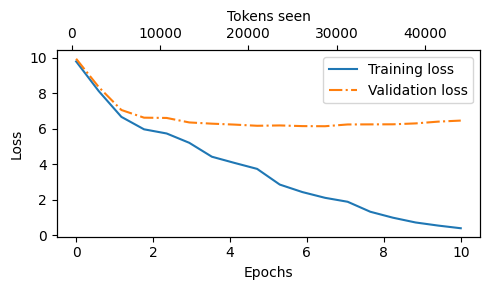

In [22]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator


def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # 绘制训练损失和验证损失
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    # X轴显示整数
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))  

    ax2 = ax1.twiny() 
    ax2.plot(tokens_seen, train_losses, alpha=0) 
    ax2.set_xlabel("Tokens seen")

    fig.tight_layout() 
    plt.savefig("loss-plot.pdf")
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

课后实验任务：在一个中文数据集上实现GPT模型预训练，并使用它生成文本